# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 212377717
~~~

~~~
STUDENT GIT LINK: https://github.com/yaelevy/Computational-Learning-and-Data-Analysis/tree/main/ex3
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_212377717.html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata

import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [2]:
config = {}
config["training_size"] = 40000
config["learning_rate"] = 0.01
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [3]:
# setup
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# data generation
class CharacterTable:
    def __init__(self, chars):
        self.chars = list(chars)
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows, maxlen):
        x = np.zeros((num_rows, maxlen), dtype=np.int64)
        for i, c in enumerate(C):
            for t, char in enumerate(c):
                x[i, t] = self.char_indices[char]
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)

# max lengths
# input: "9999+9999" -> 9 chars
MAXLEN_X = config["digits"] * 2 + 1
# output: "19998" or "-9999" -> 5 or 6 chars
MAXLEN_Y = config["digits"] + 2

def generate_data(size, digits):
    questions = []
    expected = []
    seen = set()

    while len(questions) < size:
        # generate numbers
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen: continue
        seen.add(key)

        # choose + or -
        if np.random.rand() > 0.5:
            q = '{}+{}'.format(a, b)
            ans = str(a + b)
        else:
            q = '{}-{}'.format(a, b)
            ans = str(a - b)

        # pad spaces
        q += ' ' * (MAXLEN_X - len(q))
        ans += ' ' * (MAXLEN_Y - len(ans))

        questions.append(q)
        expected.append(ans)

    return questions, expected

# generate datasets
print("Generating data...")
X_text, Y_text = generate_data(config["training_size"], config["digits"])

# encode
ct = CharacterTable(chars)
X = ct.encode(X_text, len(X_text), MAXLEN_X)
Y = ct.encode(Y_text, len(Y_text), MAXLEN_Y)

# create tensor datasets
# split into train/validation
split_idx = int(len(X) * 0.9)
train_data = TensorDataset(torch.from_numpy(X[:split_idx]), torch.from_numpy(Y[:split_idx]))
val_data = TensorDataset(torch.from_numpy(X[split_idx:]), torch.from_numpy(Y[split_idx:]))

train_loader = DataLoader(train_data, shuffle=True, batch_size=config["batch_size"])
val_loader = DataLoader(val_data, shuffle=True, batch_size=config["batch_size"])

# define model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input):
        # input shape: (batch, seq_len)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, cell):
        # input shape: (batch, 1) -> single step decoding
        output = self.embedding(input)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(chars)

        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        # encoder pass
        hidden, cell = self.encoder(source)
        decoder_input = torch.tensor([[char_to_ix[' ']]] * batch_size, device=self.device)

        for t in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)

            decoder_input = target[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# training loop
encoder = EncoderRNN(vocab_size, config["hidden_size"]).to(device)
decoder = DecoderRNN(config["hidden_size"], vocab_size).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

print(f"Starting training on {device}...")

for epoch in range(1, config["iterations"] + 1):
    model.train()
    total_loss = 0

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        output = model(x_batch, y_batch)

        # reshape for Loss
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        y_batch = y_batch.view(-1)

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 5 == 0 or epoch == 1:
        model.eval()
        total_correct = 0
        total_samples = 0

        vis_x, vis_y, vis_preds = None, None, None

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)

                preds = model(x_val, y_val, teacher_forcing_ratio=0.0)

                # calculate accuracy
                pred_indices = preds.argmax(dim=2) # Shape: (Batch, Seq_Len)

                # compare with true target
                match = (pred_indices == y_val).all(dim=1)

                total_correct += match.sum().item()
                total_samples += x_val.size(0)

                # save the last batch for visualization
                vis_x, vis_y, vis_preds = x_val, y_val, preds

        accuracy = (total_correct / total_samples) * 100
        avg_loss = total_loss / len(train_loader)

        print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Val Accuracy: {accuracy:.2f}%")

        # visualisation
        print("-" * 30)
        for j in range(5):
            input_str = "".join([ix_to_char[c.item()] for c in vis_x[j]])
            target_str = "".join([ix_to_char[c.item()] for c in vis_y[j]])

            pred_indices = vis_preds[j].argmax(1)
            pred_str = "".join([ix_to_char[c.item()] for c in pred_indices])

            is_correct = pred_str.strip() == target_str.strip()
            color = "✅" if is_correct else "❌"
            print(f"Q: {input_str} | T: {target_str} | P: {pred_str} {color}")
        print("-" * 30)

Generating data...
Starting training on cuda...
Epoch 1 | Loss: 1.2975 | Val Accuracy: 0.55%
------------------------------
Q: 3928+4    | T: 3932   | P: 3931   ❌
Q: 26+460    | T: 486    | P: 460    ❌
Q: 1+6240    | T: 6241   | P: 6231   ❌
Q: 257-641   | T: -384   | P: -261   ❌
Q: 51-419    | T: -368   | P: -411   ❌
------------------------------
Epoch 5 | Loss: 0.8599 | Val Accuracy: 2.43%
------------------------------
Q: 41+58     | T: 99     | P: 91     ❌
Q: 26-50     | T: -24    | P: -31    ❌
Q: 96-3851   | T: -3755  | P: -3787  ❌
Q: 266+366   | T: 632    | P: 661    ❌
Q: 6+799     | T: 805    | P: 800    ❌
------------------------------
Epoch 10 | Loss: 0.7399 | Val Accuracy: 5.15%
------------------------------
Q: 92-398    | T: -306   | P: -324   ❌
Q: 677-472   | T: 205    | P: 204    ❌
Q: 187-83    | T: 104    | P: 110    ❌
Q: 5+955     | T: 960    | P: 960    ✅
Q: 2-1611    | T: -1609  | P: -1619  ❌
------------------------------
Epoch 15 | Loss: 0.6725 | Val Accuracy: 8.22%

# Answers

1.2)
a) No. While this models loss is not so high the accuracy is very low. It fails on the actual logic of calculations.
It approximates a good answer but misses "carry over" operations. It gets very close answers but needs the extra mile to get 100% correct calculations.
b)
* It loses information because of the encoding to a single vector, especially on long strings.
* Math is calculated right to left, first ones then tens etc. The model can't read the last digit and hold the first digits in memory, it is too much context to hold.
* every calculation step uses the same vector without splitting and focusing on different part of the input for calculations.
c) There are several things that can be done to improve:
* reverse the input to help the model focus on bugger values, for example: 7-45 -> 54-7
the model will focus on 5 which is the tens and not 4 which is the ones.
* Add attention mechanism
d) Yes. It's the solution for Seq2Seq limitations. It solves the problem by allowing the decoder to access the entire history of encoder outputs, not just the final state. This hopefully will give better results.


# 1.3: Adding attention

In [4]:
class EncoderRNN_V2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN_V2, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded)
        return output, (hidden, cell)

# decoder with Bahdanau attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input)

        # calc attention weights
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded.squeeze(1), hidden.squeeze(0)), 1)), dim=1)

        # weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        # combine embedded input with context
        output = torch.cat((embedded.squeeze(1), attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(1)
        output = F.relu(output)

        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell, attn_weights

class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]

        outputs = torch.zeros(batch_size, target_len, len(chars)).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(source)

        decoder_input = torch.tensor([[char_to_ix[' ']]] * batch_size, device=self.device)

        for t in range(target_len):
            output, hidden, cell, _ = self.decoder(decoder_input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            decoder_input = target[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# data generation (reversed)
def generate_reversed_data(size, digits):
    questions = []
    expected = []
    seen = set()
    while len(questions) < size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen: continue
        seen.add(key)

        if np.random.rand() > 0.5:
            q = '{}+{}'.format(a, b)
            ans = str(a + b)
        else:
            q = '{}-{}'.format(a, b)
            ans = str(a - b)

        # reverse input
        q = q[::-1]

        q += ' ' * (MAXLEN_X - len(q))
        ans += ' ' * (MAXLEN_Y - len(ans))
        questions.append(q)
        expected.append(ans)
    return questions, expected

print("Regenerating Reversed Data...")
X_text, Y_text = generate_reversed_data(config["training_size"], config["digits"])
X = ct.encode(X_text, len(X_text), MAXLEN_X)
Y = ct.encode(Y_text, len(Y_text), MAXLEN_Y)

split_idx = int(len(X) * 0.9)
train_data = TensorDataset(torch.from_numpy(X[:split_idx]), torch.from_numpy(Y[:split_idx]))
val_data = TensorDataset(torch.from_numpy(X[split_idx:]), torch.from_numpy(Y[split_idx:]))

train_loader = DataLoader(train_data, shuffle=True, batch_size=config["batch_size"])
val_loader = DataLoader(val_data, shuffle=True, batch_size=config["batch_size"])

# training loop

attn_encoder = EncoderRNN_V2(vocab_size, config["hidden_size"]).to(device)
attn_decoder = AttnDecoderRNN(config["hidden_size"], vocab_size, max_length=MAXLEN_X).to(device)
attn_model = Seq2SeqAttention(attn_encoder, attn_decoder, device).to(device)

attn_optimizer = optim.Adam(attn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(f"Starting Attention Training (Reversed Input)...")

for epoch in range(1, 51):
    attn_model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        attn_optimizer.zero_grad()
        output = attn_model(x_batch, y_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        attn_optimizer.step()
        total_loss += loss.item()

    if epoch % 5 == 0 or epoch == 1:
        attn_model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                preds = attn_model(x_val, y_val, teacher_forcing_ratio=0.0)
                pred_indices = preds.argmax(dim=2)
                match = (pred_indices == y_val).all(dim=1)
                total_correct += match.sum().item()
                total_samples += x_val.size(0)

        print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f} | Val Accuracy: {(total_correct / total_samples) * 100:.2f}%")

Regenerating Reversed Data...
Starting Attention Training (Reversed Input)...
Epoch 1 | Loss: 1.3984 | Val Accuracy: 0.50%
Epoch 5 | Loss: 0.7742 | Val Accuracy: 8.77%
Epoch 10 | Loss: 0.6096 | Val Accuracy: 17.27%
Epoch 15 | Loss: 0.4523 | Val Accuracy: 32.62%
Epoch 20 | Loss: 0.2697 | Val Accuracy: 53.12%
Epoch 25 | Loss: 0.1792 | Val Accuracy: 60.32%
Epoch 30 | Loss: 0.1308 | Val Accuracy: 63.35%
Epoch 35 | Loss: 0.1122 | Val Accuracy: 65.18%
Epoch 40 | Loss: 0.0923 | Val Accuracy: 67.25%
Epoch 45 | Loss: 0.0686 | Val Accuracy: 68.15%
Epoch 50 | Loss: 0.0547 | Val Accuracy: 69.85%


Compared to the seq2seq model seen previously which achieved ~14 accuracy the addition of attention significantly improved results to ~70!!!
With same amount of epochs.

# 1.4: Improving results

In [5]:
# the transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_encoder_layers=1, num_decoder_layers=2, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=True)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)
        src = self.pos_encoder(self.embedding(src) * math.sqrt(self.d_model))
        tgt = self.pos_encoder(self.embedding(tgt) * math.sqrt(self.d_model))
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        return self.fc_out(output)

# training loop

model_t = TransformerModel(vocab_size).to(device)
optimizer_t = optim.Adam(model_t.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

print("Starting Transformer Training...")

for epoch in range(1, 101):
    model_t.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_t.zero_grad()

        # training - teacher forcing
        dec_input = y_batch[:, :-1]
        target = y_batch[:, 1:]

        output = model_t(x_batch, dec_input)

        loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
        loss.backward()
        optimizer_t.step()
        total_loss += loss.item()

    # validation
    if epoch % 5 == 0 or epoch == 1:
        model_t.eval()
        total_correct = 0
        total_chars = 0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                ys = y_val[:, 0:1]

                for i in range(y_val.shape[1] - 1):
                    out = model_t(x_val, ys)
                    prob = out[:, -1, :]
                    _, next_word = torch.max(prob, dim=1)
                    ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)

                # print results
                if total_chars == 0:
                    ix_to_char = {v: k for k, v in char_to_ix.items()}
                    pred_text = "".join([ix_to_char.get(t.item(), '?') for t in ys[0]])
                    true_text = "".join([ix_to_char.get(t.item(), '?') for t in y_val[0]])
                    print(f"\n[Epoch {epoch} Debug]")
                    print(f"Pred: '{pred_text}'")
                    print(f"True: '{true_text}'")
                    print("-" * 30)

                # cala accuracy
                min_len = min(ys.shape[1], y_val.shape[1])
                match = (ys[:, :min_len] == y_val[:, :min_len])

                total_correct += match.sum().item()
                total_chars += match.numel()

        acc = (total_correct / total_chars) * 100 if total_chars > 0 else 0
        print(f"Transformer Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f} | Char Accuracy: {acc:.2f}%")

Starting Transformer Training...

[Epoch 1 Debug]
Pred: '-5663 '
True: '-1627 '
------------------------------
Transformer Epoch 1 | Loss: 1.5483 | Char Accuracy: 48.32%

[Epoch 5 Debug]
Pred: '8303  '
True: '83    '
------------------------------
Transformer Epoch 5 | Loss: 1.3527 | Char Accuracy: 54.92%

[Epoch 10 Debug]
Pred: '161   '
True: '143   '
------------------------------
Transformer Epoch 10 | Loss: 1.2444 | Char Accuracy: 56.91%

[Epoch 15 Debug]
Pred: '-373  '
True: '-938  '
------------------------------
Transformer Epoch 15 | Loss: 1.1846 | Char Accuracy: 58.35%

[Epoch 20 Debug]
Pred: '2122  '
True: '2492  '
------------------------------
Transformer Epoch 20 | Loss: 1.1389 | Char Accuracy: 59.23%

[Epoch 25 Debug]
Pred: '292   '
True: '292   '
------------------------------
Transformer Epoch 25 | Loss: 1.0898 | Char Accuracy: 60.23%

[Epoch 30 Debug]
Pred: '1330  '
True: '1041  '
------------------------------
Transformer Epoch 30 | Loss: 1.0411 | Char Accuracy: 62.13

WOW, 94%! Much better results. (i increaseed the number of epochs for better ressullts) Why the transformer wins? It uses Self-Attention. It doesn't read left-to-right. Instead, it looks at every digit simultaneously.
It could perfectly model long-distance arithmetic dependencies (like carry-overs) that the LSTM struggled to retain over time.
This is the best model so far with highest accuracy and fastest converge.

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [6]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [7]:
# 1.a:
# Download the Hebrew-English pairs from manythings.org
!wget -q https://www.manythings.org/anki/heb-eng.zip

# Unzip the file
!unzip -q heb-eng.zip

print("Download and extraction complete.")

Download and extraction complete.


In [16]:
# 1.b:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# cleaning functions
def unicodeToAscii(s):
    # normalize unicode characters to ASCII
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s, lang_name):
    # separate punctuation
    s = re.sub(r"([.!?])", r" \1", s)

    if lang_name == "eng":
        # cleaning for english
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    else:
        # cleaning for Hebrew
        s = s.strip()
    return s

# read data
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    # read file
    lines = open('heb.txt', encoding='utf-8').read().strip().split('\n')

    # split lines into pairs and normalize
    pairs = [[normalizeString(s, l) for s, l in zip(l.split('\t')[:2], [lang1, lang2])]
             for l in lines]

    # reverse pairs: Input=Hebrew, Output=English
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

eng_prefixes = (
    "i am ", "i m ",
    "he is ", "he s ",
    "she is ", "she s ",
    "you are ", "you re ",
    "we are ", "we re ",
    "they are ", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# run preparation
input_lang, output_lang, pairs = prepareData('eng', 'heb', reverse=True)
print("\nRandom sample pair:", random.choice(pairs))

Reading lines...
Read 136845 sentence pairs
Trimmed to 9149 sentence pairs
Counting words...
Counted words:
heb 6232
eng 3047

Random sample pair: ['אני מצטער שעלי ללכת .', 'i m sorry i have to go .']


In [9]:
# 2.a:

# build and train model
batch_size = 32
dropout_p = 0.01

# model definitions (Bahdanau attention)

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # teacher forcing: feed target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # no teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# training utilities

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def get_dataloader(batch_size):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=5):
    start = time.time()
    print_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    print(f"Starting Training for {n_epochs} epochs...")
    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if epoch % print_every == 0:
            print('%s (Epoch %d %d%%) Loss: %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, loss))

# initialize data and models
train_dataloader = get_dataloader(batch_size)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=dropout_p).to(device)

# run
train(train_dataloader, encoder, decoder, n_epochs=epochs, print_every=5)

Starting Training for 50 epochs...
0m 37s (- 5m 35s) (Epoch 5 10%) Loss: 1.2422
1m 17s (- 5m 8s) (Epoch 10 20%) Loss: 0.7469
1m 53s (- 4m 23s) (Epoch 15 30%) Loss: 0.4474
2m 28s (- 3m 42s) (Epoch 20 40%) Loss: 0.2629
3m 3s (- 3m 3s) (Epoch 25 50%) Loss: 0.1543
3m 35s (- 2m 23s) (Epoch 30 60%) Loss: 0.0944
4m 6s (- 1m 45s) (Epoch 35 70%) Loss: 0.0652
4m 39s (- 1m 9s) (Epoch 40 80%) Loss: 0.0488
5m 10s (- 0m 34s) (Epoch 45 90%) Loss: 0.0408
5m 41s (- 0m 0s) (Epoch 50 100%) Loss: 0.0332


In [10]:
# 2.b:
# evaluate randomly on 20 sentences

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = torch.tensor([indexesFromSentence(input_lang, sentence) + [EOS_token]], dtype=torch.long, device=device)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

print("\n--- 2.b Evaluating 20 Random Sentences ---")
encoder.eval()
decoder.eval()

# select 20 random indices
random_indices = [random.randint(0, len(pairs) - 1) for _ in range(20)]

for i in random_indices:
    pair = pairs[i]
    print('>', pair[0])  # hebrew input
    print('=', pair[1])  # english target
    output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print('<', output_sentence) # pred
    print('-' * 10)


--- 2.b Evaluating 20 Random Sentences ---
> אנחנו כמעט סיימנו .
= we re nearly finished .
< we are nearly late alone . <EOS>
----------
> אתה חופשי ללכת .
= you re free to go .
< you are free to go . <EOS>
----------
> אני לרשותך .
= i m at your disposal .
< i m at your present . <EOS>
----------
> אתם לא גמישים .
= you re inflexible .
< you re inflexible . <EOS>
----------
> אני עושה את מה שאני אוהב .
= i m doing what i love to do .
< i m doing what i love to do . <EOS>
----------
> אני צובע את שערי לחום .
= i am dyeing my hair brown .
< he is my hair brown salary . <EOS>
----------
> אני שמחה שאינני מאחרת .
= i m glad i m not late .
< i m glad i m not late . <EOS>
----------
> היא מפחדת מחתולים .
= she is afraid of cats .
< she is afraid of cats . <EOS>
----------
> אני סתם שמח שלא נפגעת .
= i m just glad you weren t hurt .
< i m just glad you weren t hurt you .
----------
> אני מעוניינת .
= i m interested .
< i m interested in history . <EOS>
----------
> היא ממתינה לתינוק ביוני .


--- 2.c Attention Plots for 5 Random Sentences ---
Plotting for: הוא משתוקק לדבר איתך .


/tmp/ipython-input-942096120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipython-input-942096120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


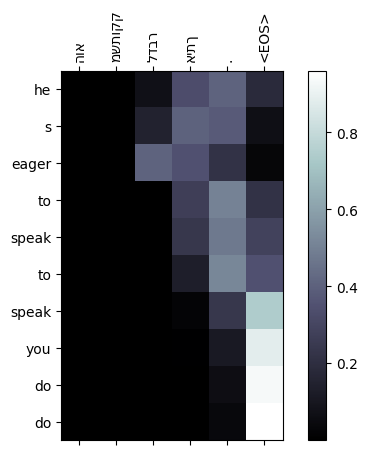

Plotting for: אני דיילת בגימלאות .


/tmp/ipython-input-942096120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipython-input-942096120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


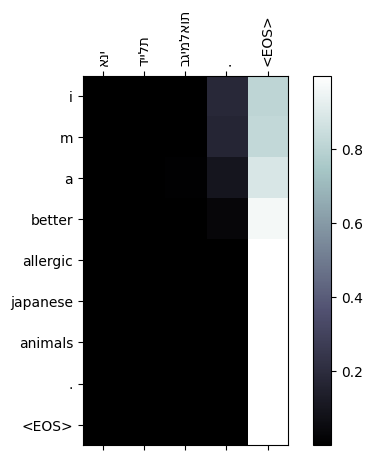

Plotting for: הוא עדיין בחיים .


/tmp/ipython-input-942096120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipython-input-942096120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


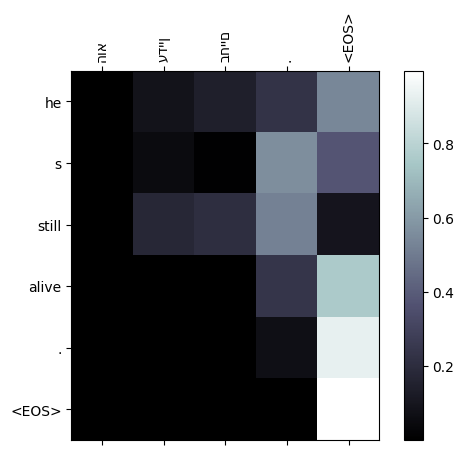

Plotting for: הוא לא מוכן .


/tmp/ipython-input-942096120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipython-input-942096120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


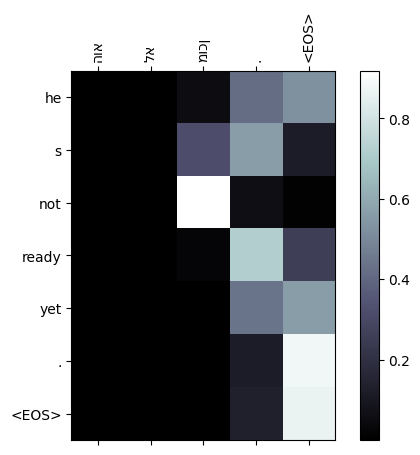

Plotting for: הוא טפש שלא ייאמן .


/tmp/ipython-input-942096120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipython-input-942096120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


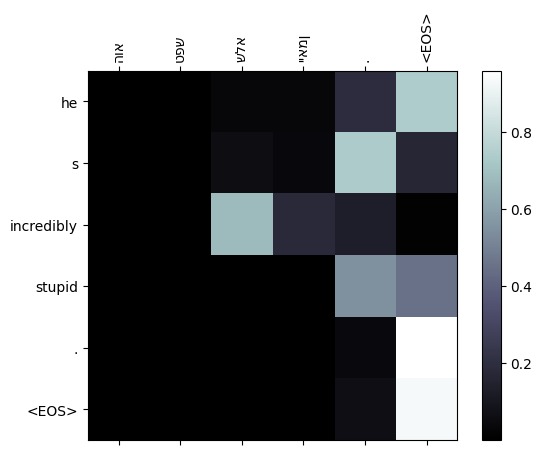

In [11]:
# 2.c:
# plot for 5 random sentences

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # visualisation
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

print("\n--- 2.c Attention Plots for 5 Random Sentences ---")

# select 5 random indices
random_indices = [random.randint(0, len(pairs) - 1) for _ in range(5)]

for i in random_indices:
    pair = pairs[i]
    print(f"Plotting for: {pair[0]}")
    output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    showAttention(pair[0], output_words, attentions[0, :len(output_words), :])

# Answers:

0.
Bahdanau vs. Luong Attention
* Alignment Score Calculation: Bahdanau uses a feed-forward neural network to calculate the alignment score. Luong uses a simpler matrix multiplication. It is computationally faster and memory-efficient.
* Decoder State Dependency:
Bahdanau calculates attention using the previous decoder hidden state and the encoder outputs.
Luong calculates attention using the current decoder hidden state, the attention is calculated after the RNN step.
* Information Flow:
Bahdanaus context vector is concatenated with the **input embedding** and inputs into the RNN cell.
Luongs context vector is concatenated with the **RNN's hidden state output** to produce the final prediction after the RNN cell.

Q3:

Yes, the model preform well for this specific task. It achieved a very low loss ~0.03 and the attention plots confirm it successfully learned to align Hebrew words to their English equivalents. However, it would likely fail on complex, real-world sentences outside the specific prefixes it was trained on.
Restricting the data to simple prefixes turned a hard translation problem into a simpler sentence completion task the model acheived to solve.

Limitations:
* The model sometimes completes sentences based on probability rather than the actual input.
* It picks the best word one by one. If it makes an error early in the sentence, it cannot go back and fix it.
* It cannot handle any word not in its small training dictionary.

How to improve?
* Force model to answer according to data without "guessing".
* Use bidirectional encoder so the encoder reads the sentence forward and backward, capturing better context.
* Instead of whole words, use subwords to handle unknown words and rich Hebrew morphology better.


In [14]:
# bidirectional encoder
class BiEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(BiEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # bidirectional=True outputs (Batch, Seq, Hidden*2)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

# attention model
class BiBahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BiBahdanauAttention, self).__init__()
        # query
        self.Wa = nn.Linear(hidden_size, hidden_size)
        # keys
        self.Ua = nn.Linear(hidden_size * 2, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        # calculate scores
        query = query.permute(1, 0, 2) # [batch, 1, hidden]
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys) # [batch, 1, hidden*2]
        return context, weights

# bidirectional decoder
class BiAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(BiAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BiBahdanauAttention(hidden_size)
        self.gru = nn.GRU(hidden_size * 3, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden[0] + encoder_hidden[1]
        decoder_hidden = decoder_hidden.unsqueeze(0)
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        # calculate attention context
        context, attn_weights = self.attention(hidden, encoder_outputs)
        # concatenate embedding and context
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

In [15]:
def train_bi_model():
    # initialize
    bi_encoder = BiEncoderRNN(input_lang.n_words, hidden_size).to(device)
    bi_decoder = BiAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

    encoder_optimizer = optim.Adam(bi_encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(bi_decoder.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    print("Starting Bidirectional Training...")
    start = time.time()
    for epoch in range(1, epochs + 1):
        loss = train_epoch(train_dataloader, bi_encoder, bi_decoder, encoder_optimizer, decoder_optimizer, criterion)

        if epoch % 5 == 0:
             print('%s (Epoch %d %d%%) Loss: %.4f' % (timeSince(start, epoch / epochs),
                                        epoch, epoch / epochs * 100, loss))
    return bi_encoder, bi_decoder

# run training
bi_encoder, bi_decoder = train_bi_model()

# evaluate comparison
print("\n--- Evaluating Bidirectional Model ---")
bi_encoder.eval()
bi_decoder.eval()

for i in range(5):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, _ = evaluate(bi_encoder, bi_decoder, pair[0], input_lang, output_lang)
    print('<', ' '.join(output_words))
    print('')

Starting Bidirectional Training...
0m 31s (- 4m 45s) (Epoch 5 10%) Loss: 1.1568
1m 2s (- 4m 11s) (Epoch 10 20%) Loss: 0.6222
1m 34s (- 3m 40s) (Epoch 15 30%) Loss: 0.3325
2m 6s (- 3m 9s) (Epoch 20 40%) Loss: 0.1775
2m 37s (- 2m 37s) (Epoch 25 50%) Loss: 0.1019
3m 8s (- 2m 5s) (Epoch 30 60%) Loss: 0.0686
3m 40s (- 1m 34s) (Epoch 35 70%) Loss: 0.0516
4m 11s (- 1m 2s) (Epoch 40 80%) Loss: 0.0416
4m 43s (- 0m 31s) (Epoch 45 90%) Loss: 0.0355
5m 14s (- 0m 0s) (Epoch 50 100%) Loss: 0.0323

--- Evaluating Bidirectional Model ---
> אני קורא ספר על בעלי חיים .
= i m reading a book about animals .
< i m reading a book about animals . <EOS>

> אני לא וותרן .
= i m no quitter .
< i m not even exist . <EOS>

> הם איומים .
= they re terrible .
< they re terrible terrible . <EOS>

> אני בבית חבר .
= i m at a friend s house .
< i am at a big friend on a friend s

> אתם מטומטמים .
= you re fools .
< you re do looking . <EOS>



Comparison:

* The Bidirectional model performed slightly better, converging faster and reaching a lower final loss. 0.0332	vs 0.0323
* the Bidirectional model shows strong grammatical structure, though it still suffers from "hallucinations" typical of small datasets.
For example (from previous runs): "I am afraid of bears."
-> prediction:
"I am afraid of wild animals."
Although it hallucinates it understands semanticaly related words.

Conclusion:
Even though the loss difference is small on this specific dataset, the Bidirectional model is better:
* it holds future context - the "whole picture" compared to the standard model - reads left-to-right.
* the context vector passed to the decoder is the concatenation of two hidden states - effectively doubles the "bandwidth" of information available to the attention mechanism, allowing it to make sharper decisions about alignment.